In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import torch
import pickle
from torch.autograd import Variable

sys.path.append('..')
sys.path.append('../visualization')
sys.path.append('../acd/util')
sys.path.append('../acd/scores')
sys.path.append('../acd/agglomeration')
import viz_1d as viz
import tiling_1d as tiling
import agg_1d as agg
import cd
import score_funcs


# form class to hold data
class B:
    def __init__(self):
        self.text = Variable(torch.zeros(1).cuda())

sys.path.append('../dsets/sst')
from dsets.sst import dset
sst_pkl = pickle.load(open('../dsets/sst/sst.pkl', 'rb'))

# load model

In [2]:
snapshot_file = '../dsets/sst/sst.model'
model = dset.get_model(snapshot_file).eval()

loading ../dsets/sst/sst.model


/accounts/projects/vision/.local/lib/python3.5/site-packages/torch/serialization.py:316: SourceChangeWarning: source code of class 'model.LSTMSentiment' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/accounts/projects/vision/.local/lib/python3.5/site-packages/torch/serialization.py:316: SourceChangeWarning: source code of class 'torch.nn.modules.sparse.Embedding' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


loaded onto gpu...


/accounts/projects/vision/.local/lib/python3.5/site-packages/torch/serialization.py:316: SourceChangeWarning: source code of class 'torch.nn.modules.rnn.LSTM' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/accounts/projects/vision/.local/lib/python3.5/site-packages/torch/serialization.py:316: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


# run examples

<class '__main__.B'>


../dsets/sst/model.py:29: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greately increasing memory usage. To compact weights again call flatten_parameters().
  lstm_out, self.hidden = self.lstm(vecs, self.hidden)
../acd/agglomeration/agg_1d.py:31: RuntimeWarning: invalid value encountered in greater_equal
  mask = scores >= thresh
/accounts/projects/vision/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4033: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


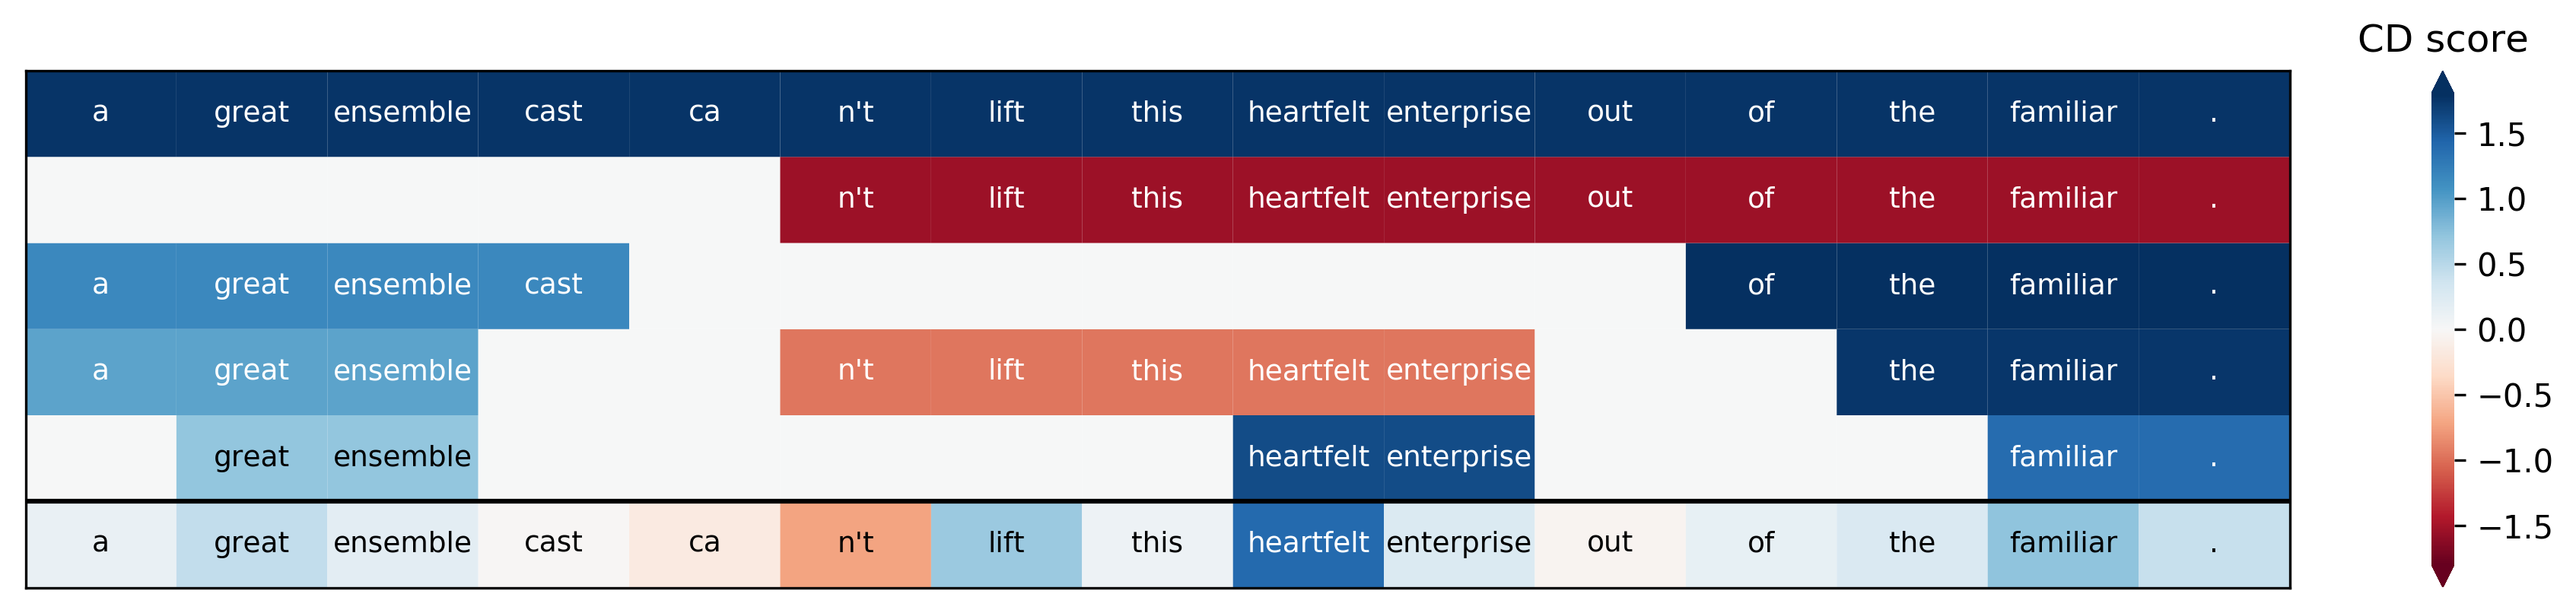

In [5]:
# base parameters
sweep_dim = 1 # how large chunks of text should be considered (1 for words)
method = 'cd' # build_up, break_down, cd
percentile_include = 90
num_iters = 25 # maximum number of iterations
# subtract = True
dset_type = 'dev' # train, dev


# any text with words from this dataset can be interpreted
sentence = ['a', 'great', 'ensemble', 'cast', 'ca', 'n\'t', 'lift', 'this', 'heartfelt', 'enterprise', 'out', 'of', 'the', 'familiar', '.'] # note this is a real example from the dataset
# sentence = ['not', 'good', ',', 'not', 'bad', ',', 'just', 'okay']
mturk = True
percentile_include = 99.5
no_text = True


def batch_from_str_list(s):
#     batch = dset.get_batches([0], train_iterator, dev_iterator)[0] # has batch.text, batch.label
#     batch = torchtext.data.Batch()
    batch = B()
    print(type(batch))
    nums = np.expand_dims(np.array([sst_pkl['stoi'][x] for x in s]).transpose(), axis=1)
    batch.text.data = torch.LongTensor(nums).cuda()
    return batch

# prepare inputs
batch = batch_from_str_list(sentence)
label_actual = 1 # 0 if positive 1 if negative
scores_all = model(batch).data.cpu().numpy()[0]
label_pred = np.argmax(scores_all)
text_orig = [sst_pkl['itos'][int(ind)] for ind in batch.text.data]

# sweep agglomerative
lists = agg.sweep_agglomerative(model, batch, percentile_include, method, sweep_dim, # only works for sweep_dim = 1
                    text_orig, label_pred, num_iters=num_iters)
lists = agg.collapse_tree(lists)

viz.word_heatmap(text_orig, lists, label_pred, label_actual, method, True, False, True)